# End-to-end notebook!

Here is the workflow:
* Sampling configs (sampling parameters, etc.) lead to...
* Weaving configs (blank model settings, donor model settings, layer assignments) lead to...
* Models (probably TFRobertaForSequenceClassification in all cases) lead to...
* Performance scores (numbers from 0-100)

In [1]:
# install dependencies

! pip install -q joblib  # joblib for memoizing functions
! pip install -q ipywidgets widgetsnbextension pandas-profiling # IProgress for progress bars

In [1]:
# Add model_merging to the python path

import os
import sys

model_merging_base = os.path.abspath("../model_merging/")
# assert it exist
assert os.path.exists(model_merging_base)
if model_merging_base not in sys.path:
    sys.path.append(model_merging_base)

In [5]:
# import joblib for caching and distributed computing
from math import sqrt

from joblib import Memory, Parallel, delayed

memory = Memory(location="cache", verbose=10)

parallel = Parallel(n_jobs=2, return_as="generator")
output_generator = parallel(delayed(sqrt)(i**2) for i in range(10))

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/joblib/parallel.py:1762: UserWarning: 4 tasks which were still being processed by the workers have been cancelled. You could benefit from adjusting the input task iterator to limit unnecessary computation time.
  warnings.warn(msg)


In [8]:
# Imports and cached functions

import os

from llm_weaver import (
    calculate_score_from_weaving_config,
    test_weaver,
)

# Disable parallelism in tokenizers to avoid deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

calculate_score_from_weaving_config_cached = memory.cache(
    calculate_score_from_weaving_config
)
test_weaver_cached = memory.cache(test_weaver)

## Step 0: Test weaving code

This test makes sure that our score when using the weaver to reconstruct a model from all its parts get the same evaluation score as the original model

In [9]:
model_ids = [
    "textattack/roberta-base-RTE",
    "textattack/roberta-base-MNLI",
]

# for model_id in model_ids:
#     test_weaver(model_id)

# You can run this more than once, and it will pull from the cache on subsequent runs
Parallel(n_jobs=2, return_as="list")(
    delayed(test_weaver_cached)(model_id) for model_id in model_ids
)

[Memory]: Loading test_weaver from cache/joblib/llm_weaver/test_weaver/10dcf0499632d2dc426a8c51f8748c07
_________________________________________test_weaver cache loaded - 0.0s, 0.0min
[Memory]: Loading test_weaver from cache/joblib/llm_weaver/test_weaver/bd08da19319cbff8cce9779ebe451148
_________________________________________test_weaver cache loaded - 0.0s, 0.0min


[({'accuracy': 0.7}, {'accuracy': 0.7}),
 ({'accuracy': 0.17}, {'accuracy': 0.17})]

## Steps 1-3: configs to graph


In [45]:
# Function to sample configs
import random

from llm_weaver import dict_overwrite, get_model_config


def sample_weave_configs_iter(p=0.5, seed=42, max_configs=1):
    # set random seed
    random.seed(seed)

    donor_model_ids = [
        "textattack/roberta-base-RTE",
        "textattack/roberta-base-MNLI",
    ]
    blank_model_config = dict_overwrite(
        get_model_config("textattack/roberta-base-RTE"),
        {
            "num_hidden_layers": 12,
        },
    )
    for _ in range(max_configs):
        config = {
            "glue_task": "rte",
            "tokenizer_model_id": "textattack/roberta-base-RTE",
            # The task (i.e. the classification head output size should match the task at hand)
            "blank_model_config": blank_model_config,
            # Layer assignments
            "layer_assignments": [
                {
                    "type": "SingleLayer",
                    "params": {
                        # Load donor model # Choose a random donor model according to the p parameter
                        "donor": random.choices(donor_model_ids, weights=[p, 1 - p])[0],
                        # Pick a layer
                        "hidden_layer_number": i,
                    },
                }
                for i in range(12)
            ],
            # The head (i.e. the classification head should match the task at hand)
            # THESE ARE DIFFERENT BETWEEN RTE AND MNLI
            "classification_head": {
                "type": "SingleClassificationHead",
                "params": {
                    "donor": "textattack/roberta-base-RTE",
                },
            },
            # The embeddings layer
            # THESE ARE DIFFERENT BETWEEN RTE AND MNLI
            "embeddings": {
                "type": "SingleEmbeddings",
                "params": {
                    "donor": "textattack/roberta-base-RTE",
                },
            },
        }
        yield config


sample_config = dict(p=0.5, seed=42, max_configs=100)

# Generate the sample configs and save to a file just in case
weave_configs = list(sample_weave_configs_iter(**sample_config))


len(weave_configs)

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


100

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/667f71624847b0c3b69b2a87d973b3a1
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/de1a309506b751a498c7f7558d603ea6
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/7aafface3666fa24d5d007289da33a67
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/00660772bcde78f2d6aea184b3c93a8d
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/job

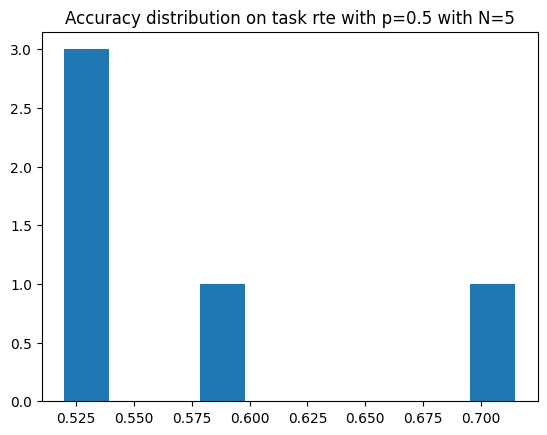

In [57]:
import matplotlib.pyplot as plt


def sample_config_to_plots(sample_config, n_jobs=5):
    weave_configs = list(
        sample_weave_configs_iter(**sample_config),
    )

    scores = Parallel(n_jobs=n_jobs, return_as="list")(
        delayed(calculate_score_from_weaving_config_cached)(
            weave_config,
            n_examples=4096,
            split="validation",
        )
        for weave_config in weave_configs
    )
    accuracies = [score["accuracy"] for score in scores]

    title = f"Accuracy distribution on task {weave_configs[0]['glue_task']} with p={sample_config['p']} with N={len(accuracies)}"

    # create figure and ax
    fig, ax = plt.subplots()
    ax.hist(accuracies, bins=10)
    ax.set_title(title)
    plt.show()

    return accuracies, weave_configs


accuracies, weave_configs = sample_config_to_plots(
    dict(p=0.5, seed=42, max_configs=5),
)

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/667f71624847b0c3b69b2a87d973b3a1
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/de1a309506b751a498c7f7558d603ea6
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/7aafface3666fa24d5d007289da33a67
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/00660772bcde78f2d6aea184b3c93a8d
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/job

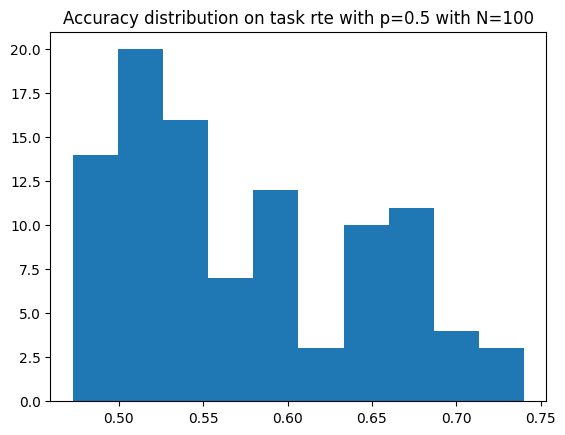

In [58]:
accuracies, weave_configs = sample_config_to_plots(
    dict(p=0.5, seed=42, max_configs=100),
)

### Investigate the models that did so well

In [65]:
# Get max accuracy index
max_accuracy_index = accuracies.index(max(accuracies))
# accuracies

# Get the best config
best_config = weave_configs[max_accuracy_index]

from pprint import pprint

pprint(max(accuracies))
pprint(best_config)

0.740072202166065
{'blank_model_config': {'add_cross_attention': False,
                        'architectures': ['RobertaForSequenceClassification'],
                        'attention_probs_dropout_prob': 0.1,
                        'bad_words_ids': None,
                        'begin_suppress_tokens': None,
                        'bos_token_id': 0,
                        'chunk_size_feed_forward': 0,
                        'classifier_dropout': None,
                        'cross_attention_hidden_size': None,
                        'decoder_start_token_id': None,
                        'diversity_penalty': 0.0,
                        'do_sample': False,
                        'early_stopping': False,
                        'encoder_no_repeat_ngram_size': 0,
                        'eos_token_id': 2,
                        'exponential_decay_length_penalty': None,
                        'finetuning_task': 'glue:rte',
                        'forced_bos_token_id': None,
 